In [2]:
!pip install -q transformers torch scikit-learn pandas numpy tqdm matplotlib sentence-transformers scipy


In [3]:
# Import Libraries
# Purpose: Load core Python, ML, and visualization tools.
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr


In [4]:
# Device Configuration
# Purpose: Detect CPU/GPU for reproducibility.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [5]:
# Load FLAN-T5-Base
# Purpose: Load an open-source, instruction-tuned LLM

MODEL_NAME = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

model.to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [6]:
# Text Generation Function
# Purpose: Generate stochastic model outputs for uncertainty analysis.

def generate_answer(prompt, temperature=0.7, max_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(
        **inputs,
        do_sample=True,
        temperature=temperature,
        max_new_tokens=max_tokens
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [7]:
# Self-Consistency Sampling
# Purpose: Generate multiple answers per question.

def self_consistency(prompt, runs=7):
    return [generate_answer(prompt) for _ in range(runs)]


In [8]:
# Syntactic Confidence Score
# Purpose: Estimate confidence using answer agreement.

def confidence_score(answers):
    unique_answers = len(set(answers))
    return 1 - (unique_answers / len(answers))


In [9]:
# Load Sentence Embedding Model
# Purpose: Enable semantic similarity analysis.

embedder = SentenceTransformer("all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# Semantic Confidence Score
# Purpose: Measure agreement based on meaning, not wording.

def semantic_confidence(answers):
    embeddings = embedder.encode(answers)
    sim_matrix = cosine_similarity(embeddings)
    upper_triangle = sim_matrix[np.triu_indices(len(answers), k=1)]
    return upper_triangle.mean()


In [11]:
dataset = [

# =========================
# 1. FACTUAL KNOWLEDGE (25)
# =========================
{"question": "Is Nigeria a member of the African Union?", "ground_truth": "Yes"},
{"question": "Is the capital of France Paris?", "ground_truth": "Yes"},
{"question": "Is water composed of hydrogen and oxygen?", "ground_truth": "Yes"},
{"question": "Is the sun a star?", "ground_truth": "Yes"},
{"question": "Is the Great Wall of China visible from space with the naked eye?", "ground_truth": "No"},
{"question": "Is Mount Everest the tallest mountain above sea level?", "ground_truth": "Yes"},
{"question": "Is Python a compiled programming language?", "ground_truth": "No"},
{"question": "Does the Earth revolve around the Sun?", "ground_truth": "Yes"},
{"question": "Is the human heart located on the right side of the chest?", "ground_truth": "No"},
{"question": "Is electricity measured in volts?", "ground_truth": "Yes"},
{"question": "Is oxygen heavier than nitrogen?", "ground_truth": "Yes"},
{"question": "Is Africa the largest continent by land area?", "ground_truth": "No"},
{"question": "Is the speed of light constant in a vacuum?", "ground_truth": "Yes"},
{"question": "Is gold a chemical element?", "ground_truth": "Yes"},
{"question": "Is Pluto classified as a planet?", "ground_truth": "No"},
{"question": "Is photosynthesis performed by animals?", "ground_truth": "No"},
{"question": "Is the Nile River the longest river in the world?", "ground_truth": "Yes"},
{"question": "Is the human genome made of DNA?", "ground_truth": "Yes"},
{"question": "Is the boiling point of water 100°C at sea level?", "ground_truth": "Yes"},
{"question": "Is sound able to travel through a vacuum?", "ground_truth": "No"},
{"question": "Is the Moon larger than Earth?", "ground_truth": "No"},
{"question": "Is iron a metal?", "ground_truth": "Yes"},
{"question": "Is the Pacific Ocean the largest ocean?", "ground_truth": "Yes"},
{"question": "Is gravity weaker on the Moon than on Earth?", "ground_truth": "Yes"},
{"question": "Is the human brain part of the central nervous system?", "ground_truth": "Yes"},

# =========================
# 2. LOGICAL / REASONING (25)
# =========================
{"question": "If all birds can fly and a penguin is a bird, can a penguin fly?", "ground_truth": "No"},
{"question": "If it is raining, does that guarantee the ground is wet?", "ground_truth": "Yes"},
{"question": "If A is greater than B and B is greater than C, is A greater than C?", "ground_truth": "Yes"},
{"question": "If a person is older than 18, are they necessarily retired?", "ground_truth": "No"},
{"question": "If two numbers are both even, is their sum even?", "ground_truth": "Yes"},
{"question": "If a statement is false, is its negation true?", "ground_truth": "Yes"},
{"question": "If someone lives in Africa, do they necessarily live in Nigeria?", "ground_truth": "No"},
{"question": "If today is Monday, is tomorrow Wednesday?", "ground_truth": "No"},
{"question": "If all mammals are animals, are all animals mammals?", "ground_truth": "No"},
{"question": "If a light is switched off, is the room necessarily dark?", "ground_truth": "No"},
{"question": "If a product costs more, is it always higher quality?", "ground_truth": "No"},
{"question": "If a number is divisible by 4, is it divisible by 2?", "ground_truth": "Yes"},
{"question": "If a car has no fuel, can it drive?", "ground_truth": "No"},
{"question": "If someone is sleeping, are they awake?", "ground_truth": "No"},
{"question": "If a triangle has three equal sides, is it equilateral?", "ground_truth": "Yes"},
{"question": "If a person is hungry, have they eaten recently?", "ground_truth": "No"},
{"question": "If all squares are rectangles, are all rectangles squares?", "ground_truth": "No"},
{"question": "If an exam is difficult, will everyone fail?", "ground_truth": "No"},
{"question": "If an object floats, is it necessarily light?", "ground_truth": "No"},
{"question": "If the power is out, can electronic devices operate normally?", "ground_truth": "No"},
{"question": "If a number is prime, is it divisible only by 1 and itself?", "ground_truth": "Yes"},
{"question": "If someone owns a car, can they necessarily drive?", "ground_truth": "No"},
{"question": "If a statement is true, can it also be false?", "ground_truth": "No"},
{"question": "If a medicine works for one person, will it work for all?", "ground_truth": "No"},
{"question": "If ice melts, does it become liquid water?", "ground_truth": "Yes"},

# =========================
# 3. POLICY / RULE-BASED (25)
# =========================
{"question": "Can a loan be approved if the borrower defaulted in the last 6 months?", "ground_truth": "No"},
{"question": "Is a passport required for international travel?", "ground_truth": "Yes"},
{"question": "Can a minor legally sign a binding contract?", "ground_truth": "No"},
{"question": "Is wearing a seatbelt legally required in many countries?", "ground_truth": "Yes"},
{"question": "Can someone vote without being a citizen?", "ground_truth": "No"},
{"question": "Is tax payment mandatory for employed individuals in most countries?", "ground_truth": "Yes"},
{"question": "Can a company operate without registration?", "ground_truth": "No"},
{"question": "Is driving under the influence of alcohol legal?", "ground_truth": "No"},
{"question": "Can an employee be paid below minimum wage legally?", "ground_truth": "No"},
{"question": "Is data protection required when handling personal data?", "ground_truth": "Yes"},
{"question": "Can a bank open an account without identity verification?", "ground_truth": "No"},
{"question": "Is child labor permitted under labor laws?", "ground_truth": "No"},
{"question": "Can a court verdict be appealed?", "ground_truth": "Yes"},
{"question": "Is insurance mandatory for motor vehicles in many countries?", "ground_truth": "Yes"},
{"question": "Can a student be expelled for academic misconduct?", "ground_truth": "Yes"},
{"question": "Is bribery legal in public office?", "ground_truth": "No"},
{"question": "Can a visa expire?", "ground_truth": "Yes"},
{"question": "Is consent required before collecting personal data?", "ground_truth": "Yes"},
{"question": "Can a contract be enforced if signed under duress?", "ground_truth": "No"},
{"question": "Is plagiarism acceptable in academic work?", "ground_truth": "No"},
{"question": "Can intellectual property be legally protected?", "ground_truth": "Yes"},
{"question": "Is fraud considered a criminal offense?", "ground_truth": "Yes"},
{"question": "Can a minor obtain a driver’s license?", "ground_truth": "No"},
{"question": "Is freedom of speech unlimited in all jurisdictions?", "ground_truth": "No"},
{"question": "Can laws change over time?", "ground_truth": "Yes"},

# =========================
# 4. ECONOMIC / CONCEPTUAL (25)
# =========================
{"question": "Does inflation reduce purchasing power?", "ground_truth": "Yes"},
{"question": "Can interest rates be negative?", "ground_truth": "Yes"},
{"question": "Does higher demand generally increase prices?", "ground_truth": "Yes"},
{"question": "Is scarcity a fundamental economic concept?", "ground_truth": "Yes"},
{"question": "Does saving money always increase wealth?", "ground_truth": "No"},
{"question": "Is unemployment measured as a percentage of the labor force?", "ground_truth": "Yes"},
{"question": "Does diversification reduce investment risk?", "ground_truth": "Yes"},
{"question": "Is GDP a measure of economic output?", "ground_truth": "Yes"},
{"question": "Does a budget deficit mean government revenue exceeds spending?", "ground_truth": "No"},
{"question": "Is opportunity cost the value of the next best alternative?", "ground_truth": "Yes"},
{"question": "Can inflation occur without economic growth?", "ground_truth": "Yes"},
{"question": "Does monopoly reduce market competition?", "ground_truth": "Yes"},
{"question": "Is supply independent of price?", "ground_truth": "No"},
{"question": "Can taxes influence consumer behavior?", "ground_truth": "Yes"},
{"question": "Is money neutral in the short run?", "ground_truth": "No"},
{"question": "Does economic recession imply negative growth?", "ground_truth": "Yes"},
{"question": "Is a higher interest rate likely to reduce borrowing?", "ground_truth": "Yes"},
{"question": "Does price elasticity measure responsiveness to price changes?", "ground_truth": "Yes"},
{"question": "Is trade beneficial to all parties involved?", "ground_truth": "No"},
{"question": "Can government spending stimulate an economy?", "ground_truth": "Yes"},
{"question": "Does inflation always harm the economy?", "ground_truth": "No"},
{"question": "Is profit equal to revenue minus cost?", "ground_truth": "Yes"},
{"question": "Can a currency depreciate?", "ground_truth": "Yes"},
{"question": "Is economic growth evenly distributed?", "ground_truth": "No"},
{"question": "Does productivity growth increase long-term output?", "ground_truth": "Yes"}
]

len(dataset)

100

In [12]:
# Full Experiment
# Purpose: Collect predictions, confidence, and correctness.

results = []

for item in tqdm(dataset):
    question = item["question"]
    gt = item["ground_truth"]

    answers = self_consistency(question)
    final_answer = answers[0]

    results.append({
        "question": question,
        "ground_truth": gt,
        "final_answer": final_answer,
        "confidence_sc": confidence_score(answers),
        "confidence_semantic": semantic_confidence(answers),
        "correct": int(gt.lower() in final_answer.lower()),
        "all_answers": answers
    })

df = pd.DataFrame(results)
df.head(1)


100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


,question,ground_truth,final_answer,confidence_sc,confidence_semantic,correct,all_answers
0,Is Nigeria a member of the African Union?,Yes,no,0.714286,0.923856,0,"[no, yes, yes, yes, yes, yes, yes]"


In [13]:
# Add Category Labels
# Purpose: Enable per-category failure analysis.

categories = (
    ["Factual"] * 25 +
    ["Logical"] * 25 +
    ["Policy"] * 25 +
    ["Economic"] * 25
)

df["category"] = categories
df.head()


,question,ground_truth,final_answer,confidence_sc,confidence_semantic,correct,all_answers,category
0,Is Nigeria a member of the African Union?,Yes,no,0.714286,0.923856,0,"[no, yes, yes, yes, yes, yes, yes]",Factual
1,Is the capital of France Paris?,Yes,no,0.714286,0.873093,0,"[no, no, no, yes, no, no, yes]",Factual
2,Is water composed of hydrogen and oxygen?,Yes,no,0.714286,0.847712,0,"[no, yes, yes, no, yes, no, yes]",Factual
3,Is the sun a star?,Yes,no,0.714286,0.847712,0,"[no, no, yes, yes, no, no, yes]",Factual
4,Is the Great Wall of China visible from space ...,No,yes,0.714286,0.847712,0,"[yes, no, no, yes, no, no, yes]",Factual


In [14]:
# Basic Accuracy Metrics
# Purpose: High-level performance overview.

df["correct"].mean()


np.float64(0.44)

In [15]:
# Correlation Analysis
# Purpose: Test alignment between confidence and correctness.

pearson_sc = pearsonr(df["confidence_sc"], df["correct"])
pearson_sem = pearsonr(df["confidence_semantic"], df["correct"])

spearman_sc = spearmanr(df["confidence_sc"], df["correct"])
spearman_sem = spearmanr(df["confidence_semantic"], df["correct"])

pearson_sc, pearson_sem, spearman_sc, spearman_sem


(PearsonRResult(statistic=np.float64(0.08495533587137453), pvalue=np.float64(0.40068801077239435)),
 PearsonRResult(statistic=np.float64(0.12404629991173712), pvalue=np.float64(0.21883839290134888)),
 SignificanceResult(statistic=np.float64(0.12487834556381733), pvalue=np.float64(0.21573996872031)),
 SignificanceResult(statistic=np.float64(0.13057511030855037), pvalue=np.float64(0.19535947984150132)))

In [16]:
# Calibration Bins
# Purpose: Analyze confidence calibration.

def calibration_bins(conf, correct, bins=5):
    temp = pd.DataFrame({"conf": conf, "correct": correct})
    temp["bin"] = pd.cut(temp["conf"], bins=bins)
    return temp.groupby("bin")["correct"].mean()

cal_sc = calibration_bins(df["confidence_sc"], df["correct"])
cal_sem = calibration_bins(df["confidence_semantic"], df["correct"])

cal_sc, cal_sem


/tmp/ipython-input-3984452161.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return temp.groupby("bin")["correct"].mean()
/tmp/ipython-input-3984452161.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return temp.groupby("bin")["correct"].mean()


(bin
 (-0.000857, 0.171]    0.333333
 (0.171, 0.343]        0.500000
 (0.343, 0.514]        0.500000
 (0.514, 0.686]        0.250000
 (0.686, 0.857]        0.469136
 Name: correct, dtype: float64,
 bin
 (0.152, 0.322]    0.000000
 (0.322, 0.492]    0.400000
 (0.492, 0.661]    0.222222
 (0.661, 0.831]    0.500000
 (0.831, 1.0]      0.468354
 Name: correct, dtype: float64)

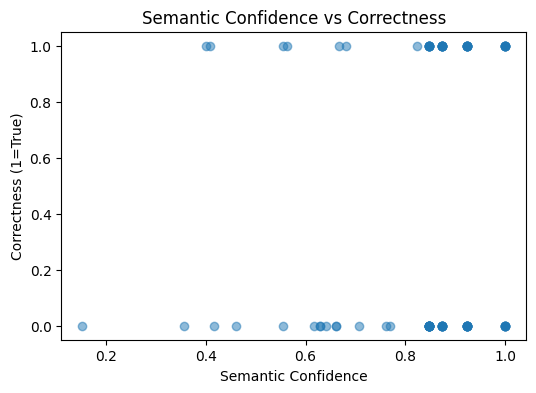

In [17]:
# Confidence vs Correctness Plot
# Purpose: Visual diagnostic for miscalibration.

plt.figure(figsize=(6,4))
plt.scatter(df["confidence_semantic"], df["correct"], alpha=0.5)
plt.xlabel("Semantic Confidence")
plt.ylabel("Correctness (1=True)")
plt.title("Semantic Confidence vs Correctness")
plt.show()


In [18]:
# Identify High-Confidence Errors
# Purpose: Core failure cases (research highlight).

high_conf_errors = df[
    (df["confidence_semantic"] > 0.75) &
    (df["correct"] == 0)
]

high_conf_errors[["question", "final_answer", "confidence_semantic", "category"]].head(10)




,question,final_answer,confidence_semantic,category
0,Is Nigeria a member of the African Union?,no,0.923856,Factual
1,Is the capital of France Paris?,no,0.873093,Factual
2,Is water composed of hydrogen and oxygen?,no,0.847712,Factual
3,Is the sun a star?,no,0.847712,Factual
4,Is the Great Wall of China visible from space ...,yes,0.847712,Factual
7,Does the Earth revolve around the Sun?,no,0.873093,Factual
12,Is the speed of light constant in a vacuum?,no,1.000000,Factual
17,Is the human genome made of DNA?,no,0.923856,Factual
18,Is the boiling point of water 100°C at sea level?,no,0.873093,Factual
22,Is the Pacific Ocean the largest ocean?,no,1.000000,Factual


In [19]:
# Failure Rate by Category
# Purpose: Understand domain-specific weaknesses.

category_summary = df.groupby("category").agg(
    accuracy=("correct", "mean"),
    avg_confidence=("confidence_semantic", "mean")
)

category_summary


,accuracy,avg_confidence
category,,
Economic,0.32,0.764059
Factual,0.52,0.897459
Logical,0.40,0.871347
Policy,0.52,0.804943


In [20]:
# Failure Type Annotation
# Purpose: Qualitative failure taxonomy.

df["failure_type"] = df.apply(
    lambda x: "High-Confidence Error" if (x["confidence_semantic"] > 0.75 and x["correct"] == 0)
    else "Low-Confidence Correct" if (x["confidence_semantic"] < 0.4 and x["correct"] == 1)
    else "Normal",
    axis=1
)

df["failure_type"].value_counts()


,count
failure_type,
Normal,56
High-Confidence Error,44


In [21]:
# Example Failure Cases
# Purpose: Evidence table for paper.

df[df["failure_type"] == "High-Confidence Error"][
    ["question", "final_answer", "confidence_semantic", "category"]
].head(5)


,question,final_answer,confidence_semantic,category
0,Is Nigeria a member of the African Union?,no,0.923856,Factual
1,Is the capital of France Paris?,no,0.873093,Factual
2,Is water composed of hydrogen and oxygen?,no,0.847712,Factual
3,Is the sun a star?,no,0.847712,Factual
4,Is the Great Wall of China visible from space ...,yes,0.847712,Factual


In [22]:
# Save Results
# Purpose: Reproducibility & sharing.

df.to_csv("full_llm_failure_results.csv", index=False)
category_summary.to_csv("category_summary.csv")
